### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

#import statmorph
import time



import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [2]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [3]:
from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

good_gids = np.array([gal['img_name'] for gal in all_gals])
cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

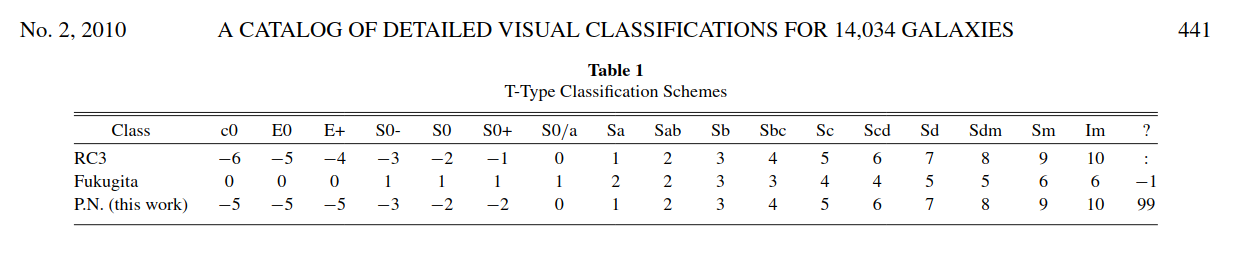

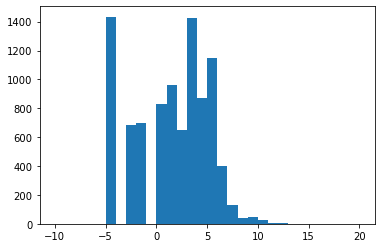

In [4]:
plt.hist(cat['TT'], range=[-10,20], bins=30)
plt.show()

2 groups : [-5, -1],        [3,5]

4 groups : [-5, -1], [0,2], [3,5], [6,9]  

6 groups : [-5,-5], [-3, -1], [0,2], [3,4], [5,6], [7,9]

8 groups : [-5,-5], [-3, -1], [0,1], [2,3], [4,5], [6,7], [8,9], [10, ~]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

In [5]:
## Runtime config.

fields = ['gini', 'm20']#, 'concentration', 'asymmetry', 'smoothness']
label_field = 'TT'


ngroups = 4

bins = [[-5,0,3,6,10], 
        [-5,0,3,6,10], 
        [-5,-3,0,3,5,7,10], 
        [-5,-3,0,2,4,6,8,10,15]]
bin_masks = [[1,0,1,0,0], 
             [1,1,1,1,0], 
             [1,1,1,1,1,1,0],
             [1,1,1,1,1,1,1,1,0]]

this_bin = bins[1]
bin_mask = bin_masks[1]

In [6]:
from astrobf.morph import custom_morph

def labeler(results, bins, field='ttype'):
    return np.digitize(results[field], bins, right=False) -1


def sample_in_bins(cat, ngroups, label_field='TT'):
    cat.loc[:, 'label'] = labeler(cat, bins=this_bin, field=label_field) # pd automatically appends a new column

    uind = cat['label'].unique()
    
    assert len(uind) == len(bin_mask)
    glabels_keep = [i for i,flag in zip(uind, bin_mask) if flag]

    return cat[cat['label'].isin(glabels_keep)].to_records(index=False)

subcat = sample_in_bins(cat, ngroups)
print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

# of sub sample: 9313


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Catalog에서 outlier를 버렸으므로 원래의 catalog/all_gals보다 길이가 짧은 result_arr가 나옴. 
시작할 때 sample을 정하고, 나머지는 잘라버린 뒤에 optimization을 수행하는게 맞을 듯. 

그럼 good_gids도 업데이트해야됨. 


이거 머리 아프니까 한 덩어리로 합치면 좋겠는데.! 

class dataset():
    def __init__(self):

In [45]:
def run_morph_in_parts(galaxies, catalog, plist, ngroups):
    """
    measure morphology parameters of each class and return merged array of results.
    
    parameters
    ----------
    galaxies:
        list of Galaxy data set (image, name, slice)
    catalog:
        ndarray containing ID, Label (and t-type)
    plist:
        list of tmo parameters
    ngroups:
        number of groups
    """
    assert len(plist) == ngroups, "ngroups and number of TMO parameters don't match"
    
    result_list = []
    for i in range(ngroups):
        result_list.append(custom_morph.step_simple_morph(galaxies, 
                                                          plist[i], 
                                                          np.where(catalog['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}

    # sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(catalog["ID"])
    result_arr = result_arr[inds]
    return result_arr

In [10]:
from functools import partial

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(custom_morph.step_simple_morph(sub_gals, 
                                                          plist[i], 
                                                          np.where(subcat['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

In [11]:
params_test = {'b0': 1,'c0': 2,'dl0': 3,'dh0': 4,
               'b1': 1,'c1': 2,'dl1': 3,'dh1': 4,
               'b2': 1,'c2': 2,'dl2': 3,'dh2': 4,
               'b3': 1,'c3': 2,'dl3': 3,'dh3': 4}

In [ ]:
ax_params = []
for i in range(ngroups):
    ax_params.append(
        {"name":f"b{i}", "type":"range", "bounds":[1.5,8.0], "value_type":"float"})
    ax_params.append(
        {"name":f"c{i}", "type":"range", "bounds":[1.5,8.0], "value_type":"float"})
    ax_params.append(
        {"name":f"dl{i}", "type":"range", "bounds":[1.0,15.0], "value_type":"float"})
    ax_params.append(
        {"name":f"dh{i}", "type":"range", "bounds":[1.0,15.0], "value_type":"float"})

# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'

for fn_result, cluster_method in zip(["FMS_2G_2p_ward", "FMS_2G_2p_spec", "FMS_2G_2p_agg"][:1],
                                     ['ward', 'spectral', 'agglomerate'][:1]):

    axc = AxClient()

    axc.create_experiment(
        parameters=ax_params,
        objective_name="mymetric",
        #minimize=True,  # Optional, defaults to False.
        parameter_constraints=[f"b{i} - dl{i} <= 100" for i in range(ngroups)], # all images are stretched to 100
        overwrite_existing_experiment =True,
        outcome_constraints=["total_flux >= 1e-5"],  # Optional.
    )

    all_metrics=[]
    for i in range(500):
        parameters, trial_index = axc.get_next_trial()
        axc.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters, cluster_method=cluster_method))
        if i % 50 == 49:
            print(f"{i}-th done")

    pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

    if True:
        axc.save_to_json_file(exp_dir+fn_result+".json")
    else:
        axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

In [6]:
# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'

for fn_result, cluster_method in zip(["FMS_2G_2p_spec", "FMS_2G_2p_agg", "FMS_2G_2p_ward"],
                                     ['spectral', 'agglomerate', 'ward']):

    axc = AxClient()

    axc.create_experiment(
        parameters=[
            {"name": "b",
            "type": "range",
            "bounds": [1.0, 4.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False},
            {"name": "b2",
            "type": "range",
            "bounds": [1.0, 4.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False},
            {"name": "c",
            "type": "range",
            "bounds": [0.5, 5.0]},
            {"name": "c2",
            "type": "range",
            "bounds": [0.5, 5.0]},
            {"name": "dl",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dl2",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dh",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dh2",
            "type": "range",
            "bounds": [0.5, 8.0]},
        ],
        objective_name="mymetric",
        #minimize=True,  # Optional, defaults to False.
        parameter_constraints=["b - dl <= 100"], # all images are stretched to 100
        overwrite_existing_experiment =True,
        outcome_constraints=["total_flux >= 1e-5"],  # Optional.
    )

    all_metrics=[]
    for i in range(500):
        parameters, trial_index = axc.get_next_trial()
        axc.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters, cluster_method=cluster_method))
        if i % 50 == 49:
            print(f"{i}-th done")

    pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

    if True:
        axc.save_to_json_file(exp_dir+fn_result+".json")
    else:
        axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

[INFO 05-20 12:34:21] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 05-20 12:34:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-20 12:34:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-20 12:34:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dl. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-20 12:34:21] ax.service.util

KeyboardInterrupt: 

In [47]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

In [37]:
def ext_single_param(parameters, suffix):
    dd =[]
    for (kk,vv) in parameters.items():
        if suffix in kk:
            dd.append((kk.replace(suffix,''),vv))
    return dict(dd)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.show()
plt.savefig(fn_result+"param_evol.png")

print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

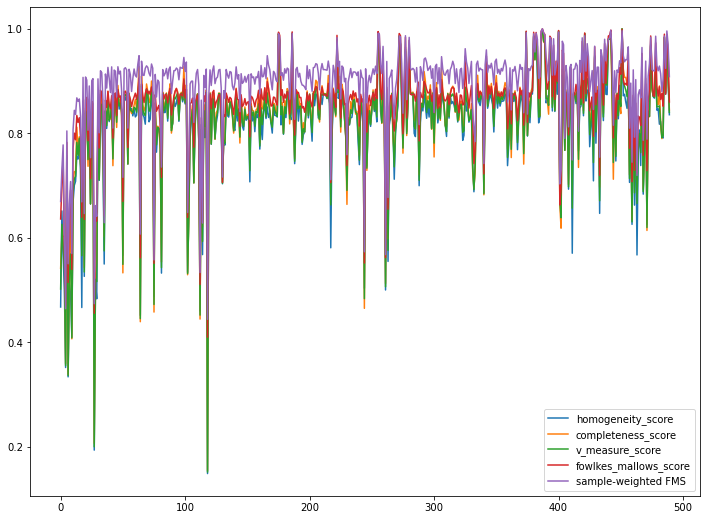

[INFO 05-24 12:56:46] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


     Generation Step Generation Model  Trial Index Trial Status  \
0                  0            Sobol            0    COMPLETED   
1                  0            Sobol            1    COMPLETED   
2                  0            Sobol            2    COMPLETED   
3                  0            Sobol            3    COMPLETED   
4                  0            Sobol            4    COMPLETED   
..               ...              ...          ...          ...   
495                1             GPEI          495    COMPLETED   
496                1             GPEI          496    COMPLETED   
497                1             GPEI          497    COMPLETED   
498                1             GPEI          498    COMPLETED   
499                1             GPEI          499    COMPLETED   

                                 Arm Parameterizations  
0    {'0_0': {'b0': 3.04, 'c0': 7.01, 'dl0': 10.84,...  
1    {'1_0': {'b0': 4.33, 'c0': 2.56, 'dl0': 3.83, ...  
2    {'2_0': {'b0': 3.04

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



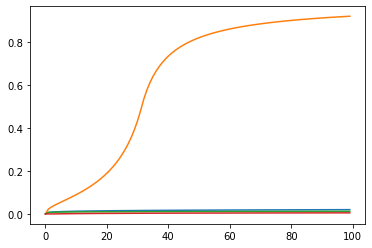

In [38]:
best_parameters, values = axc.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
for i in range(ngroups):
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **ext_single_param(best_parameters, f"{i}")))
    

parameters들 normalize가 안 된듯?? 
각각의 모양은 그럴싸함. 

## Prototypical samples

In [103]:
from astrobf import analysis
from astrobf.analysis import multi_clustering

best_parameters, values = axc.get_best_parameters()

plist = []
for i in range(ngroups):
    plist.append(ext_single_param(best_parameters, f"{i}"))
best_results = run_morph_in_parts(sub_gals, subcat, plist, ngroups)

#best_results = custom_morph.step_simple_morph(all_gals, best_parameters)
Full_exp.add_ttype(best_results, subcat)

best_eval_metrics, best_clustering = Full_exp.do_ML(best_results, partial(labeler, bins=this_bin), subcat,
                                         fields=['gini', 'm20'], 
                                          n_clusters=4,
                                         return_cluster=True,
                                         cluster_method="ward",
                                         eval_weight='area')

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-45-1670a5c913b0>:23: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


In [50]:
typicals=[]
for i in range(ngroups):
    this_clu = best_results[best_clustering.labels_ == i]
    #this_ind = analysis.utils.get_typical_ind(this_clu, n_samples=5)
    typicals.append((this_clu, this_ind))
    

/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/utils.py:11: RuntimeWarning:

Mean of empty slice.

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



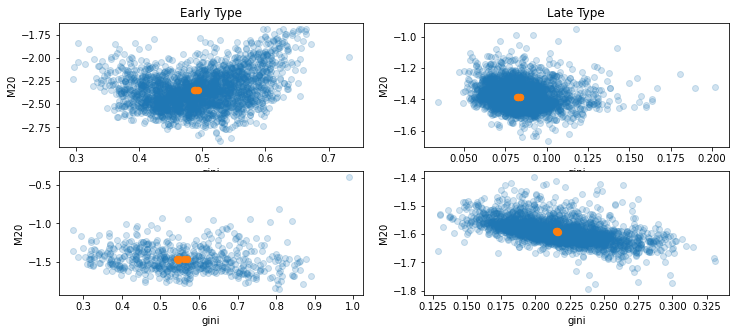

In [76]:
# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
fig.set_size_inches(12,5)
for i in range(ngroups):
    ax = axs[i]
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])

plt.show()

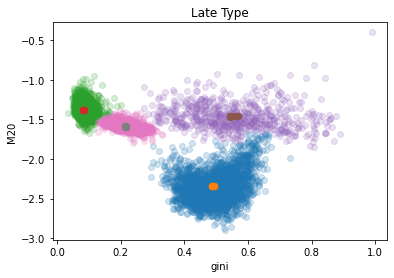

In [102]:
fig, ax = plt.subplots()

for i in range(ngroups):
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])

plt.show()

In [94]:
importlib.reload(multi_clustering)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

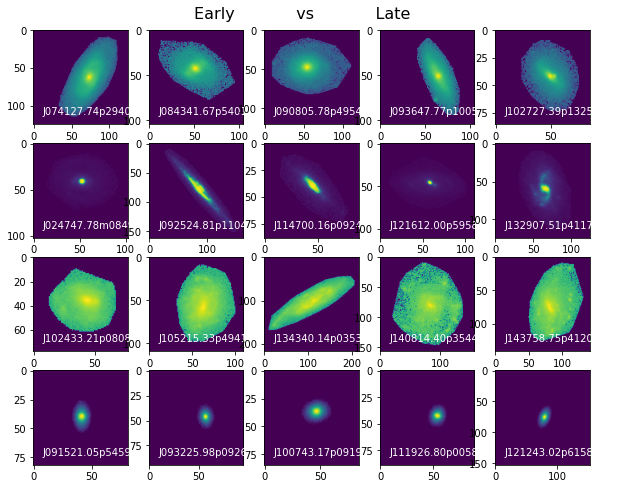

In [95]:
multi_clustering.plot_group_comparison(typicals, plist, 4,
                      suptitle="Early            vs            Late")

## Typical sampes at incremental points 

### Get the 'incremental' points

<ipython-input-101-e87ee213ac40>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-101-e87ee213ac40>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-101-e87ee213ac40>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-101-e87ee213ac40>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



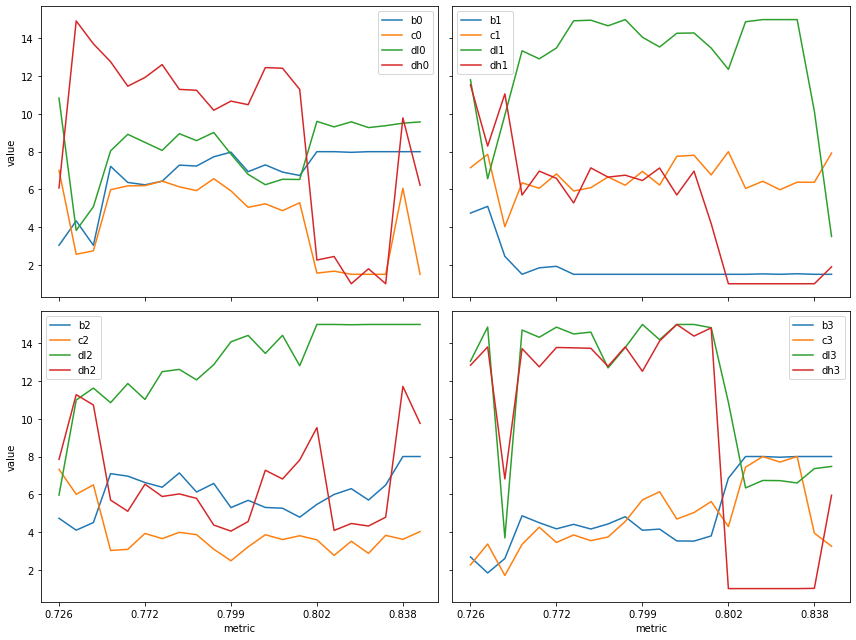

In [101]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

fig,axs = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(12,9)
axs = axs.ravel()
for i in range(ngroups):    
    ax = axs[i]
    for field in param_arr.dtype.names:
        if f"{i}" in field:
            ax.plot(param_arr[field], label=field)

    ax.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
    ax.legend()
axs[2].set_xlabel("metric")
axs[3].set_xlabel("metric")
axs[0].set_ylabel("value")
axs[2].set_ylabel("value")
plt.tight_layout()
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [87]:
#typical_E_result = analysis.utils.get_matched_result(best_results, [gal['img_name'] for gal in typical_E])
#typical_L_result = analysis.utils.get_matched_result(best_results, [gal['img_name'] for gal in typical_L])

for i, best_params in enumerate(incr_params):
    try:
        multi_clustering.plot_group_comparison(typicals, plist, 4,
                              fn=f'typical_{i}.png',
                              suptitle=f"scroe: {scores[i_incr[i]]:.4f}")

        this_results = custom_morph.step_simple_morph(sub_gals, plist)
        Full_exp.add_ttype(this_results, cat)

        eval_metrics, clustering = Full_exp.do_ML(this_results, partial(labeler, bins=this_bin), subcat,
                                         fields=['gini', 'm20'], 
                                          n_clusters=4,
                                         return_cluster=True,
                                         cluster_method="ward",
                                         eval_weight='area')

        # Get typicals
        typicals=[]
        for i in range(ngroups):
            this_clu = best_results[clustering.labels_ == i]
            #this_ind = analysis.utils.get_typical_ind(this_clu, n_samples=5)
            typicals.append((this_clu, this_ind))
    
        
        typical_L_this_result = analysis.utils.get_matched_result(this_results, 
                                                   [gal['img_name'] for gal in typical_L])

        multi_clustering.plot_group_evals_w_centers((clu1,clu2), 
                               (typical_E_result, typical_L_result),
                               (clu1_this, clu2_this), 
                               (typical_E_this_result, typical_L_this_result),
                               fn=f"G_M{i}.png")

        multi_clustering.plot_classification_vs_answer(this_results, (clu1, clu2), labeler,
                                        fn=f"current_in_best_color{i}.png")
    except:
        continue

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536
